# Group 9 assignment output

## Titles extraction

In [47]:
import urllib.request
import bs4 as bs
import time
import datetime

import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
t_df = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

num_tickers = 500

tickers = list(t_df["Symbol"][0:num_tickers])

#tickers = ["TSLA",  "EBAY", "META" ]   # for test
#print(tickers)

In [ ]:
#STOCK

sleep_time  = 5

def extract_dates(parsed_doc):
    from math import floor
    today = datetime.datetime.now().date()
    dates = parsed_doc.find_all('pubdate')
    list_date = []
    for date  in dates:
        d = datetime.datetime.strptime( date.text, "%a, %d %b %Y %H:%M:%S GMT" )
        list_date += [floor((today - d.date()).days / 1)]                          #.days
    return list_date


def get_titles(ticker, sleep_time):
    '''
    This function return the url response from google news and parsed html for a stock ticker.
    The time parameter is the sleep time before each request
    '''
    url = 'https://news.google.com/rss/search?hl=en-US&q='+ticker+'%20stock&gl=US&ceid=US:en'

    time.sleep(sleep_time) ## wait 15 seconds between each request. This is SUPER IMPORTANT otherwise your IP-address will be banned for sending too frequent requests.

    doc = urllib.request.urlopen(url).read()
    parsed_doc = bs.BeautifulSoup(doc,'lxml')
    titles = parsed_doc.find_all('title')[1:]
    list_date = extract_dates(parsed_doc)                 # we  assume/have verified that the date are extracted in the same order as the titles
    dct = {"Ticker": [ ticker ]*len(titles) , "Titles" : titles, "Date" : list_date}
    title_df = pd.DataFrame(dct)
    title_df = title_df.sort_values(by="Date")
    title_df = title_df[title_df["Date"]==0]
    return title_df

list_df = []                        #dictionary with input data
for ticker in tickers:
    title = get_titles(ticker, sleep_time)
    list_df.append(title)
    print(title)

#input_df = pd.DataFrame(dct.values(),index = tickers,columns=["Titles"])

In [ ]:
input_df = pd.concat(list_df)
input_df.shape
input_df.head()

In [ ]:
sleep_time = 5
threshold = 0.01

def get_var_prc(ticker, sleep_time):
    tickerData = yf.Ticker(ticker)
    time.sleep(sleep_time)  # Wait between requests
    df = tickerData.history()
    if len(df) < 2:
        print(f"Insufficient data for {ticker}")
        return None
    df['Change'] = df['Close'].diff()
    return df["Change"].iloc[-1] / df["Close"].iloc[-2]  # Use iloc for integer indexing

def get_target(x):
    if x < -threshold:
        return -1
    elif abs(x) < threshold:
        return 0
    else:
        return 1



# Add a new column 'Var_prc' and assign values to it
for ticker in input_df['Ticker']:
    var_prc = get_var_prc(ticker, sleep_time)
    if var_prc is not None:  # Check if data is available
        input_df.loc[input_df["Ticker"] == ticker, 'Var_prc'] = var_prc
        input_df.loc[input_df["Ticker"] == ticker, 'Target'] = input_df[input_df["Ticker"] == ticker]['Var_prc'].apply(get_target)
input_df.sample(n=5)

In [52]:
today_date = datetime.datetime.today().strftime('%d%m')

filename = f"data_{today_date}_(puntoevirgola).csv"
input_df.to_csv(filename,sep=";")


'data_3105_(puntoevirgola).csv'

## Dataset building

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install ktrain
#!pip install sentence_transformers
#!pip install --upgrade transformers==4.37.2     # otherwise ktrain.get_learner() does not work https://github.com/amaiya/ktrain/issues/523

First we import the necessary libraries and load the csv

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

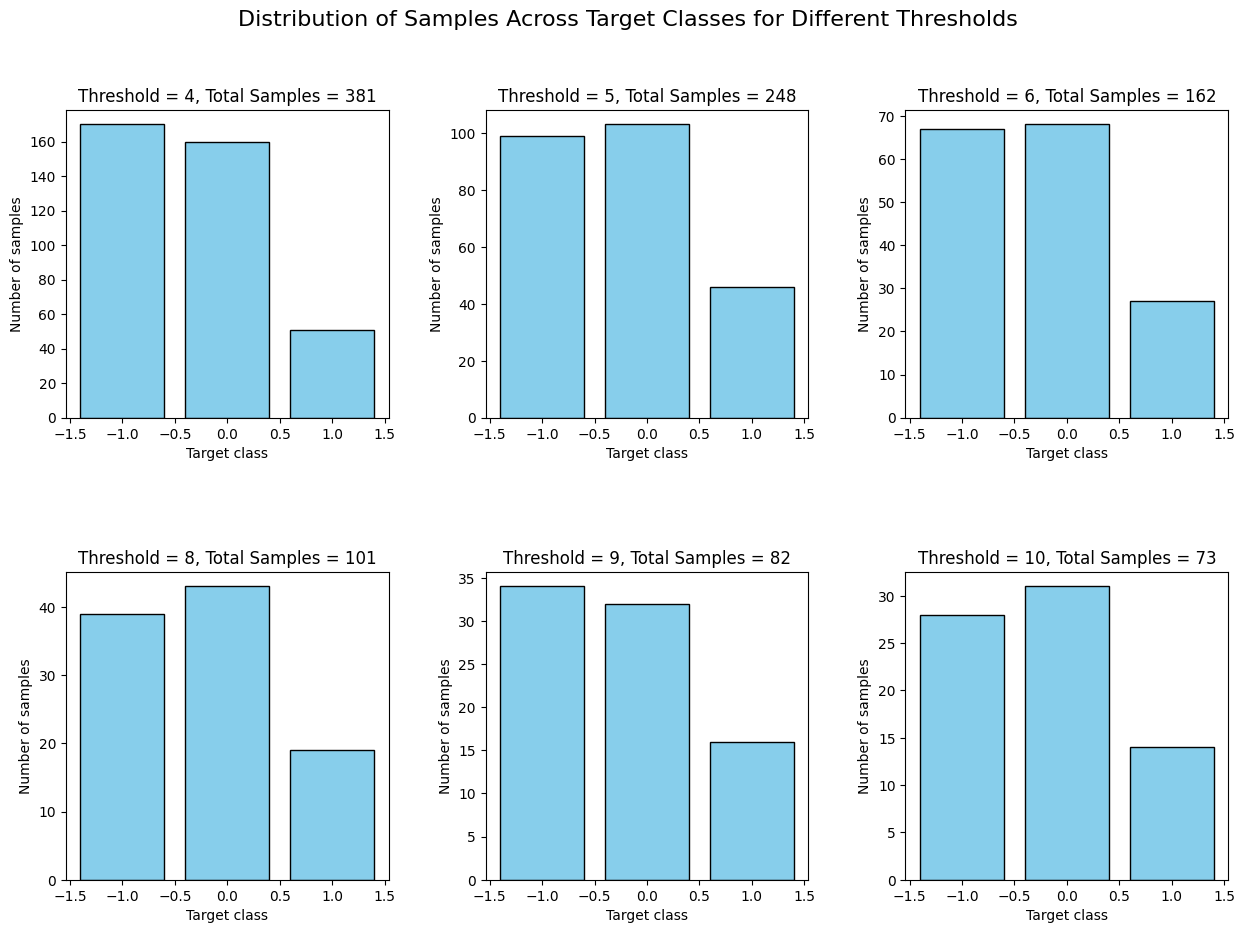

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["/data_2805(puntoevirgola).csv", "/data_2905(puntoevirgola).csv","/data_3005(puntoevirgola).csv"]
path = "/content/drive/MyDrive/0.CARMAN_PROJECT/Friday_update_21_50/Data"      #path to Data folder
file_list_1 = [ path+s for s in file_list_1 ]
#file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

for i, T in enumerate(threshold):
    row_index = i // 3
    col_index = i % 3

    all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold

    for file_name in file_list_1:
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            if len(articles_list) >= T:
                articles_list = articles_list[:T]
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()


We choose T = 4, the dataset is strongly unbalanced

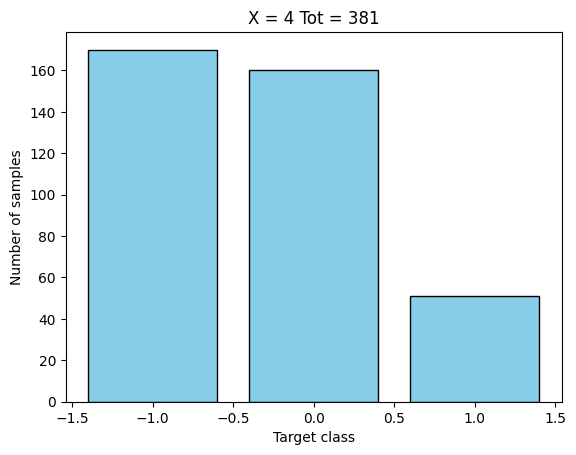

[170, 160, 51]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
368,CRM,"Salesforce Stock: Salesforce Earnings Beat, Re...",Dow Jones Futures Fall As Salesforce Plunges A...,"Salesforce (CRM) Q1 Earnings Top, Stock Falls ...","Stock Market News Today, 5/30/24 – Futures Dow...",,,,,,,-1.0,"Salesforce Stock: Salesforce Earnings Beat, Re..."
291,UAL,United Airlines Holdings Inc (UAL) Upgraded to...,Dynamic Technology Lab Private Ltd Makes New I...,United Airlines sets its Q2 profit guidance sl...,Is a Beat in Store for Frontline (FRO) in Q1 E...,,,,,,,1.0,United Airlines Holdings Inc (UAL) Upgraded to...
102,PAYC,Here's Why You Should Buy Paycom Software (PAY...,Advisory Services Network LLC Purchases 85 Sha...,StockNews.com Upgrades Paycom Software (NYSE:P...,Why Is Paycom (PAYC) Down 14.7% Since Last Ear...,,,,,,,-1.0,Here's Why You Should Buy Paycom Software (PAY...


In [5]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
T = 4
for file_name in file_list_1:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

input_df = input_df.dropna()
'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

'''
plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df.sample(n=3)

Now we divide the dataset in training set, validation set and test set

In [6]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1
y_test = y_test + 1
y_val = y_val + 1

## Model training and validation

### bert-base-multilingual-uncased

In [7]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_val = transformer.preprocess_test(list(x_val["Concatenated Titles"]), list(y_val["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 55
	95percentile : 68
	99percentile : 75


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:768: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 56
	95percentile : 66
	99percentile : 68


In [9]:
model = transformer.get_classifier()
batch_size = 5
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
48/48 [==============================] - 58s 573ms/step - loss: 25.8785 - accuracy: 0.3792


/usr/local/lib/python3.10/dist-packages/ktrain/lroptimize/lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


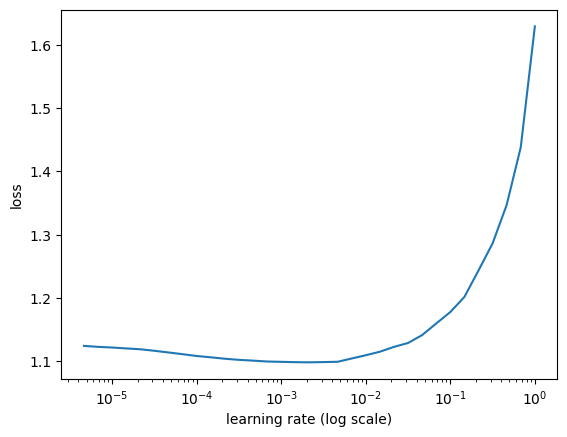

In [10]:
learner.lr_find(show_plot=True,  max_epochs=1)

In [15]:
learner.fit_onecycle(1e-3, 2)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/2
49/49 [==============================] - 30s 600ms/step - loss: 1.0050 - accuracy: 0.4568 - val_loss: 0.9906 - val_accuracy: 0.4426
Epoch 2/2
49/49 [==============================] - 30s 615ms/step - loss: 1.0566 - accuracy: 0.4691 - val_loss: 0.9211 - val_accuracy: 0.4754


In [16]:
learner.validate(class_names=transformer.get_classes())

2/2 [==============================] - 1s 275ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.64        29
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00         5

    accuracy                           0.48        61
   macro avg       0.16      0.33      0.21        61
weighted avg       0.23      0.48      0.31        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[29,  0,  0],
       [27,  0,  0],
       [ 5,  0,  0]])

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
y_val_pred_labels  = np.zeros( x_val.shape[0])
for i in range(x_val.shape[0]):
    y_val_pred_labels[i] = predictor.predict(x_val["Concatenated Titles"].iloc[i])

y_val_pred_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It always predicts class DOWN... not really good

### distilroberta-finetuned

In [20]:
model_name = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
transformer = text.Transformer(model_name, maxlen=512, class_names= np.array([0,1,2]))

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [21]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_val = transformer.preprocess_test(list(x_val["Concatenated Titles"]), list(y_val["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 55
	95percentile : 68
	99percentile : 75


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:768: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 56
	95percentile : 66
	99percentile : 68


In [22]:
model = transformer.get_classifier()
batch_size = 5
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
48/48 [==============================] - 26s 294ms/step - loss: 52.4551 - accuracy: 0.3833


/usr/local/lib/python3.10/dist-packages/ktrain/lroptimize/lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


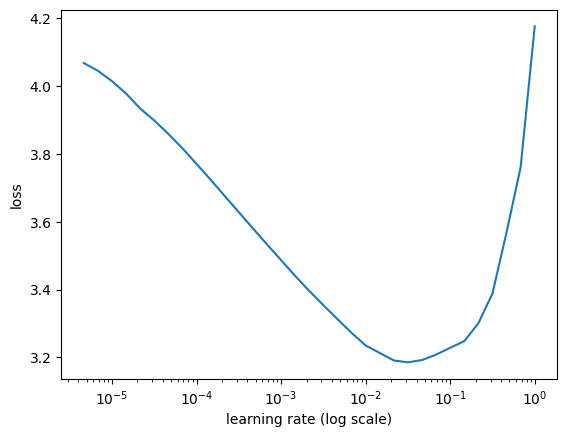

In [23]:
learner.lr_find(show_plot=True,  max_epochs=1)

Something is clearly wrong

In [24]:
learner.fit_onecycle(0.5e-1, 2)



begin training using onecycle policy with max lr of 0.05...
Epoch 1/2
49/49 [==============================] - 26s 335ms/step - loss: 8.9649 - accuracy: 0.3539 - val_loss: 17.2750 - val_accuracy: 0.4754
Epoch 2/2
49/49 [==============================] - 15s 300ms/step - loss: 12.1594 - accuracy: 0.4115 - val_loss: 14.1906 - val_accuracy: 0.4426


In [25]:
learner.validate(class_names=transformer.get_classes())

2/2 [==============================] - 2s 294ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.44      1.00      0.61        27
           2       0.00      0.00      0.00         5

    accuracy                           0.44        61
   macro avg       0.15      0.33      0.20        61
weighted avg       0.20      0.44      0.27        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 29,  0],
       [ 0, 27,  0],
       [ 0,  5,  0]])

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
y_val_pred_labels  = np.zeros( x_val.shape[0])
for i in range(x_val.shape[0]):
    y_val_pred_labels[i] = predictor.predict(x_val["Concatenated Titles"].iloc[i])

y_val_pred_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Predicts only class FLAT

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


# Make predictions
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

# Evaluate on the validation set
# Make predictions on the validation dataset
pred_val_labels = predictor.predict(x_val["Concatenated Titles"].tolist())


# Convert predictions to integers
pred_val_labels = [int(pred) for pred in pred_val_labels]

# Evaluate validation set performance
print("Validation Set Classification Report:")
print(classification_report(y_val["Target"], pred_val_labels, target_names=['Class 0', 'Class 1', 'Class 2']))

print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val["Target"], pred_val_labels))

# Evaluate on the final test set
# Make predictions on the final test dataset
pred_test_labels = predictor.predict(x_test["Concatenated Titles"].tolist())

# Convert predictions to integers
pred_test_labels = [int(pred) for pred in pred_test_labels]

# Evaluate final test set performance
print("Final Test Set Classification Report:")
print(classification_report(y_test["Target"], pred_test_labels, target_names=['Class 0', 'Class 1', 'Class 2']))

print("Final Test Set Confusion Matrix:")
print(confusion_matrix(y_test["Target"], pred_test_labels))


Validation Set Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        29
     Class 1       0.44      1.00      0.61        27
     Class 2       0.00      0.00      0.00         5

    accuracy                           0.44        61
   macro avg       0.15      0.33      0.20        61
weighted avg       0.20      0.44      0.27        61

Validation Set Confusion Matrix:
[[ 0 29  0]
 [ 0 27  0]
 [ 0  5  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Test Set Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        33
     Class 1       0.36      1.00      0.53        28
     Class 2       0.00      0.00      0.00        16

    accuracy                           0.36        77
   macro avg       0.12      0.33      0.18        77
weighted avg       0.13      0.36      0.19        77

Final Test Set Confusion Matrix:
[[ 0 33  0]
 [ 0 28  0]
 [ 0 16  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Text2vec-base-multilingual

In [29]:
from sentence_transformers import SentenceTransformer

model_name = 'shibing624/text2vec-base-multilingual'
m = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/88.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [30]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_val.shape[0]    # dim dataset
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_val.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_test.shape[0]    # dim dataset
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [32]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train.Target.iloc[i])
    y_train_dummy[i, class_idx] = 1


y_val_dummy = np.zeros((len(y_val), num_classes))
for i in range(0,len(y_val)):
  y_val_dummy[i,round(y_val.Target.iloc[i])] = 1

y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test.Target.iloc[i])] = 1

In [33]:
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_val_raw=model.predict(x_val_emb)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [35]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.45901639344262296
<function create_m1 at 0x7c9197d98820>
5
5
3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step
Precision (train): 0.699484856559197
Recall (train): 0.6831275720164609
F1-score (train): 0.653977110904144
Precision (val): 0.5065105386416863
Recall (val): 0.5409836065573771
F1-score (val): 0.5177938382592004
Precision (test): 0.3417606236680571
Recall (test): 0.4155844155844156
F1-score (test): 0.3679690242190242
MSE_train: 0.1605729382892367
MSE_val: 0.19286411496599878
MSE_test: 0.21786155829317475
MSE_train (binary): 0.2112482853223594
MSE_val (binary): 0.30601092896174864
MSE_test (binary): 0.38961038961038963
Misclassification_train: 0.3168724279835391
Misclassification_val: 0.45901639344262296
Misclassification_test: 0.5844155844155844


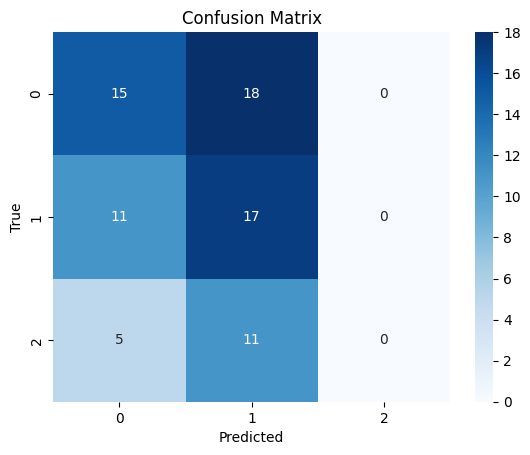

In [38]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)

# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy, pred_train)
MSE_val = mean_squared_error(y_val_dummy, pred_val)
MSE_test = mean_squared_error(y_test_dummy, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)


def misclassification_rate(y_true, y_pred):
    #return np.mean(np.abs(y_pred - y_true) / 2)
    return np.sum(y_pred != y_true) / y_true.shape[0]


miss_train = misclassification_rate(y_train_dummy.argmax(axis=1), pred_train_2.argmax(axis=1))
miss_val = misclassification_rate(y_val_dummy.argmax(axis=1), pred_val_2.argmax(axis=1))
miss_test = misclassification_rate(y_test_dummy.argmax(axis=1), pred_test_2.argmax(axis=1))

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### all-MiniLM-L6-v2

In [39]:
m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # the most downloaded sentence transformer

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [40]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_val.shape[0]    # dim dataset
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_val.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_test.shape[0]    # dim dataset
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_val_raw=model.predict(x_val_emb)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [44]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.4098360655737705
<function create_m2 at 0x7c9197d99cf0>
3
8
3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step
Precision (train): 0.524495826681017
Recall (train): 0.5967078189300411
F1-score (train): 0.5564714212874898
Precision (val): 0.5413369135104579
Recall (val): 0.5901639344262295
F1-score (val): 0.5646715552654816
Precision (test): 0.30774423934478656
Recall (test): 0.38961038961038963
F1-score (test): 0.34376998214010096
MSE_train: 0.1958602834889893
MSE_val: 0.192489671779276
MSE_test: 0.21439389592147695
MSE_train (binary): 0.26886145404663925
MSE_val (binary): 0.273224043715847
MSE_test (binary): 0.4069264069264069
Misclassification_train: 0.40329218106995884
Misclassification_val: 0.4098360655737705
Misclassification_test: 0.6103896103896104


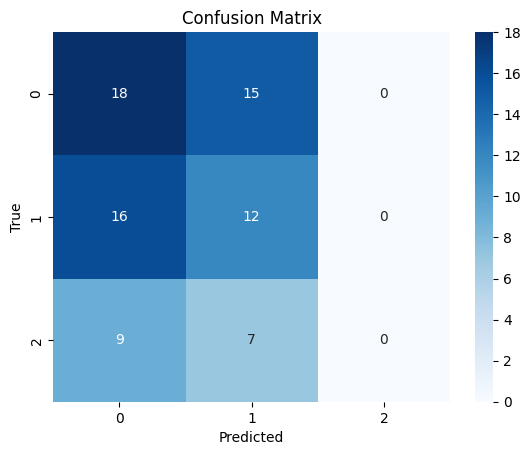

In [45]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)

# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy, pred_train)
MSE_val = mean_squared_error(y_val_dummy, pred_val)
MSE_test = mean_squared_error(y_test_dummy, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)


def misclassification_rate(y_true, y_pred):
    #return np.mean(np.abs(y_pred - y_true) / 2)
    return np.sum(y_pred != y_true) / y_true.shape[0]


miss_train = misclassification_rate(y_train_dummy.argmax(axis=1), pred_train_2.argmax(axis=1))
miss_val = misclassification_rate(y_val_dummy.argmax(axis=1), pred_val_2.argmax(axis=1))
miss_test = misclassification_rate(y_test_dummy.argmax(axis=1), pred_test_2.argmax(axis=1))

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Test set and conclusions

Based on the performance on the validation set we choose the model XXXXXXXXXXX because ...